In [ ]:
!pip install transformers datasets accelerate bitsandbytes

In [ ]:
! pip install beautifulsoup4
! pip install lxml
! pip install evaluate

In [ ]:
import seaborn as sns
from sklearn import preprocessing
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils import resample


In [ ]:
# MAKING SURE WE ARE USING GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Import Data
from google.colab import drive
drive.mount('/content/drive')
X_test = pd.read_csv('/content/drive/MyDrive/BTAI/tweetsum_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/BTAI/tweetsum_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/BTAI/tweetsum_val.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def clean(test,train,val):
  # Col for Word Count
  train['word_count']=train['sentence'].apply(lambda x:str(len(x.split())))
  test['word_count']=test['sentence'].apply(lambda x:str(len(x.split())))
  val['word_count']=val['sentence'].apply(lambda x:str(len(x.split())))

  #adding a new column to X_train "is_question" that flags true for question senteces and false for non-question sentences
  question_words = ["who", "what", "when", "where", "why", "how", "if"]
  train['is_question'] = (train['sentence'].str.endswith('?') | train['sentence'].str.lower().str.contains(fr'\b(?:{"|".join(question_words)})\b'))
  test['is_question'] = (train['sentence'].str.endswith('?') | train['sentence'].str.lower().str.contains(fr'\b(?:{"|".join(question_words)})\b'))
  val['is_question'] = (train['sentence'].str.endswith('?') | train['sentence'].str.lower().str.contains(fr'\b(?:{"|".join(question_words)})\b'))

  # # Drop sender, annot_id, dialog_id, and Unnamed: 0
  # train.drop(['sender', 'annot_id', 'dialog_id', 'Unnamed: 0'], axis = 1, inplace = True)
  # test.drop(['sender', 'annot_id', 'dialog_id', 'Unnamed: 0'], axis = 1, inplace = True)
  # val.drop(['sender', 'annot_id', 'dialog_id', 'Unnamed: 0'], axis = 1, inplace = True)

  return test,train,val

In [ ]:
test_clean,train_clean,val_clean=clean(X_test,X_train,X_val)

In [ ]:
test_clean

,Unnamed: 0,dialog_id,annot_id,sender,sentence,is_salient,word_count,is_question
0,0,bbde6d8ec7c39c4551da1ff6024f997b,0,customer,@hulu_support My watchlist is not updating wit...,True,12,False
1,1,bbde6d8ec7c39c4551da1ff6024f997b,1,customer,@hulu_support My watchlist is not updating wit...,True,12,False
2,2,bbde6d8ec7c39c4551da1ff6024f997b,2,customer,@hulu_support My watchlist is not updating wit...,True,12,False
3,3,bbde6d8ec7c39c4551da1ff6024f997b,0,customer,Any idea why?,False,3,True
4,4,bbde6d8ec7c39c4551da1ff6024f997b,1,customer,Any idea why?,False,3,True
...,...,...,...,...,...,...,...,...
7131,7131,9a3b6233ce2a7b762424ddd3b9557dfa,3,agent,@350562 Kindly DM https://t.co/jF6LqBUAqM your...,True,16,True
7132,7132,9a3b6233ce2a7b762424ddd3b9557dfa,0,agent,^SD,False,1,True
7133,7133,9a3b6233ce2a7b762424ddd3b9557dfa,1,agent,^SD,False,1,True
7134,7134,9a3b6233ce2a7b762424ddd3b9557dfa,2,agent,^SD,False,1,True


In [ ]:
train_clean["sentence"][0]

'So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.'

In [ ]:
#Modifying sentence column so that the other features of word length, is question or not is also taken in by the BERT model
def add_AllFeatures(file):
  for i in range(len(file)):
    file.loc[i,"sentence"]=file.loc[i,"sentence"]+" Annotator is "+str(file.loc[i,"annot_id"])+"."+" Sentence length is "+ str(file.loc[i,"word_count"])+"."
    if(file.loc[i,"is_question"]==True):
      file.loc[i,"sentence"]=file.loc[i,"sentence"]+" Question."
    else:
      file.loc[i,"sentence"]=file.loc[i,"sentence"]+" Not Question."
    file.loc[i,"sentence"]=file.loc[i,"sentence"]+" The sender is "+file.loc[i,"sender"]+"."



In [ ]:
add_AllFeatures(test_clean)
add_AllFeatures(val_clean)
add_AllFeatures(train_clean)

In [ ]:
print(train_clean["sentence"][0])

So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Annotator is 0. Sentence length is 22. Not Question. The sender is customer.


In [ ]:
#Making is_salient column be either 0 or 1
#train_clean['is_salient']=train_clean['is_salient'].apply(lambda x: 1 if x==True else 0)
#val_clean['is_salient']=val_clean['is_salient'].apply(lambda x: 1 if x==True else 0)
#test_clean['is_salient']=test_clean['is_salient'].apply(lambda x: 1 if x==True else 0)

In [ ]:
#We also need to make the labels be of a specific format for Hugging Face
def add_newLabel(df):
  le = preprocessing.LabelEncoder()
  le.fit(df["is_salient"].tolist())
  df["label"] = le.transform(df["is_salient"].tolist())
add_newLabel(train_clean)
add_newLabel(val_clean)
add_newLabel(test_clean)

In [ ]:
train_clean #False 1, True 0

,Unnamed: 0,dialog_id,annot_id,sender,sentence,is_salient,word_count,is_question,label
0,0,b065262210783596c1fe79466b8f8985,0,customer,So neither my iPhone nor my Apple Watch are re...,True,22,False,1
1,1,b065262210783596c1fe79466b8f8985,1,customer,So neither my iPhone nor my Apple Watch are re...,True,22,False,1
2,2,b065262210783596c1fe79466b8f8985,2,customer,So neither my iPhone nor my Apple Watch are re...,True,22,False,1
3,3,b065262210783596c1fe79466b8f8985,0,customer,Any ideas? Annotator is 0. Sentence length is ...,False,2,True,0
4,4,b065262210783596c1fe79466b8f8985,1,customer,Any ideas? Annotator is 1. Sentence length is ...,False,2,True,0
...,...,...,...,...,...,...,...,...,...
51478,51478,da32c7eb1693234417600b1bd3d3dcfc,1,agent,Our support team will look into this. Annotato...,True,7,False,1
51479,51479,da32c7eb1693234417600b1bd3d3dcfc,0,agent,Pls provide the previously requested info so I...,True,10,False,1
51480,51480,da32c7eb1693234417600b1bd3d3dcfc,1,agent,Pls provide the previously requested info so I...,False,10,False,0
51481,51481,da32c7eb1693234417600b1bd3d3dcfc,0,agent,^RP https://t.co/q1oBDuYAdh Annotator is 0. Se...,False,2,False,0


In [ ]:
#filter_test=test_clean.groupby(["sentence","is_salient"]).sample(frac=0.5, replace=False)
#print("try",filter_test)
#filter_test=filter_test.append(test_clean[test_clean["is_salient"]==True].sample(frac=0.04))
#print(len(filter_test))
#filter_test["is_salient"].unique()

In [ ]:
#Filering dataset to not into run time issues when running
#filter_train=train_clean.groupby(["sentence","is_salient"]).sample(frac=0.04, replace=False)
#print(filter_train)
#filter_train=filter_train.append(train_clean[train_clean["is_salient"]==1].sample(frac=0.04))
#len(filter_train)
#filter_train

In [ ]:
#filter_val=val_clean.groupby(["sentence","is_salient"]).sample(frac=0.04, replace=False)
#filter_val=filter_val.append(val_clean[val_clean["is_salient"]==1].sample(frac=0.04))
#print(len(filter_val))


In [ ]:
#filter_train=filter_train.append(filter_val)
new_train_clean=train_clean.append(val_clean)
new_train_clean
print(len(new_train_clean))


57991


<ipython-input-19-40e415937564>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_clean=train_clean.append(val_clean)


In [ ]:
#Upsampling dataset
minority_upsampled = resample(new_train_clean[new_train_clean["label"]==1],
             replace=True,
             n_samples=len(new_train_clean[new_train_clean["label"]==0])-len(new_train_clean[new_train_clean["label"]==1]),
             random_state=42)


In [ ]:
new_train_clean=new_train_clean.append(minority_upsampled)


In [ ]:
print(len(new_train_clean))
print("In test number of non salient",len(test_clean[test_clean["label"]==0]))
print("Number of non salients in new_train_clean", len(new_train_clean[new_train_clean["label"]==0]))
print("Number of  salients in new_train_clean", len(new_train_clean[new_train_clean["label"]==1]))

127237
In test number of non salient 5771
Number of non salients in new_train_clean 46307
Number of  salients in new_train_clean 80930


<ipython-input-57-014645009222>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_clean=new_train_clean.append(minority_upsampled)


In [ ]:
new_train_clean[new_train_clean["label"]==0]

,Unnamed: 0,dialog_id,annot_id,sender,sentence,is_salient,word_count,is_question,label
3,3,b065262210783596c1fe79466b8f8985,0,customer,Any ideas? Annotator is 0. Sentence length is ...,False,2,True,0
4,4,b065262210783596c1fe79466b8f8985,1,customer,Any ideas? Annotator is 1. Sentence length is ...,False,2,True,0
5,5,b065262210783596c1fe79466b8f8985,2,customer,Any ideas? Annotator is 2. Sentence length is ...,False,2,True,0
6,6,b065262210783596c1fe79466b8f8985,0,customer,https://t.co/m9DPQbkftD Annotator is 0. Senten...,False,1,False,0
7,7,b065262210783596c1fe79466b8f8985,1,customer,https://t.co/m9DPQbkftD Annotator is 1. Senten...,False,1,False,0
...,...,...,...,...,...,...,...,...,...
6503,6503,d00ae1831d8514a018d66c4bcb840f39,1,agent,Please let us know if you still have any issue...,False,12,True,0
6504,6504,d00ae1831d8514a018d66c4bcb840f39,2,agent,Please let us know if you still have any issue...,False,12,True,0
6505,6505,d00ae1831d8514a018d66c4bcb840f39,0,agent,-Steffi Annotator is 0. Sentence length is 1. ...,False,1,True,0
6506,6506,d00ae1831d8514a018d66c4bcb840f39,1,agent,-Steffi Annotator is 1. Sentence length is 1. ...,False,1,True,0


In [ ]:
#Converting to Hugging Face Usable formats
train_dataset = Dataset.from_pandas(new_train_clean)
#val_dataset=Dataset.from_pandas(filter_val) Not needed as the process already creates a validation set
test_dataset = Dataset.from_pandas(test_clean)
print(test_dataset)


Dataset({
    features: ['Unnamed: 0', 'dialog_id', 'annot_id', 'sender', 'sentence', 'is_salient', 'word_count', 'is_question', 'label'],
    num_rows: 7136
})


In [ ]:
model_name = "distilbert-base-uncased"


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/92614 [00:00<?, ? examples/s]

In [ ]:
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/7136 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
metric = evaluate.load("accuracy")


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Hyperparameters.

num_train_epochs = 2
learning_rate = 2e-4
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
weight_decay = 0.01

In [ ]:
evaluation_strategy = "epoch"
logging_strategy = "epoch"

training_args = TrainingArguments(
    output_dir="./results_tweets",
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    evaluation_strategy=evaluation_strategy,
    logging_strategy=logging_strategy,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.695100,0.697782,0.191284


TrainOutput(global_step=11577, training_loss=0.6951019954030621, metrics={'train_runtime': 824.4139, 'train_samples_per_second': 112.339, 'train_steps_per_second': 14.043, 'total_flos': 1330058061884280.0, 'train_loss': 0.6951019954030621, 'epoch': 1.0})

In [ ]:
#trainer.save_model("spam_model")


In [ ]:
# Evaluating on the training data.

preds = trainer.predict(tokenized_train)
preds = np.argmax(preds[:3][0], axis=1)
GT = new_train_clean["label"].tolist()
print(classification_report(GT, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     46307
           1       0.50      1.00      0.67     46307

    accuracy                           0.50     92614
   macro avg       0.25      0.50      0.33     92614
weighted avg       0.25      0.50      0.33     92614



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluating on the testing data.

preds = trainer.predict(tokenized_test)
preds = np.argmax(preds[:3][0], axis=1)
GT = test_clean["label"].tolist()
print(classification_report(GT, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5771
           1       0.19      1.00      0.32      1365

    accuracy                           0.19      7136
   macro avg       0.10      0.50      0.16      7136
weighted avg       0.04      0.19      0.06      7136



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(GT)
print( preds)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
bert_auc=roc_auc_score(GT, preds)
bert_auc=round(bert_auc,4)
print(" AUC_ROC Score",bert_auc)

 AUC_ROC Score 0.5


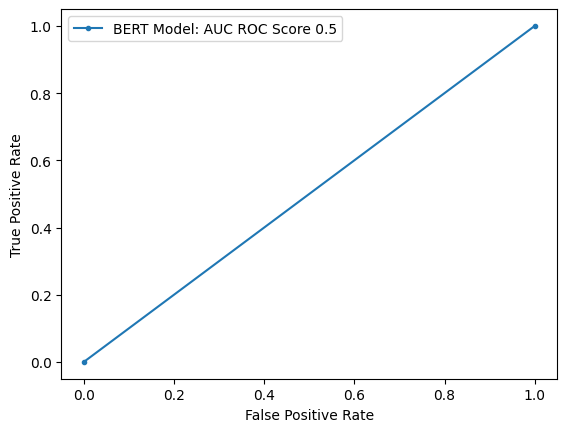

In [ ]:
bert_auc_fpr, bert_auc_tpr, _ = roc_curve(GT, preds)
plt.plot(bert_auc_fpr,bert_auc_tpr, marker='.', label='BERT Model: AUC ROC Score '+str(bert_auc))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

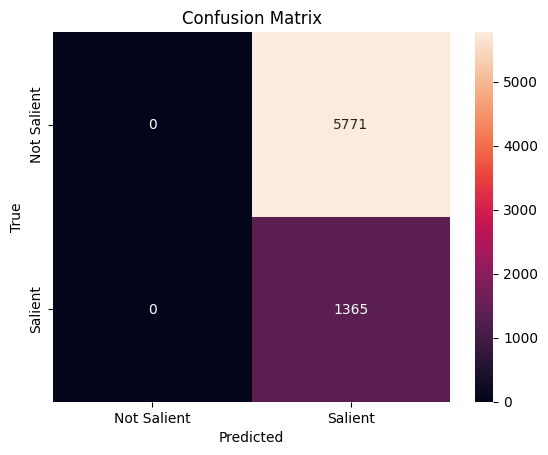

In [ ]:
cm = confusion_matrix(GT, preds)
cm = confusion_matrix(GT, preds)
sns.heatmap(cm,
            annot=True,
            fmt="g",
            xticklabels=["Not Salient","Salient"],
            yticklabels=["Not Salient","Salient"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
